In [2]:
!pip install openpyxl

In [16]:
import pandas as pd
data = pd.read_excel('app_data.xlsx')
data

,Age,BMI,Sex,Height,Weight,Length_of_Stay,Management,Severity,Diagnosis_Presumptive,Diagnosis,...,Abscess_Location,Pathological_Lymph_Nodes,Lymph_Nodes_Location,Bowel_Wall_Thickening,Conglomerate_of_Bowel_Loops,Ileus,Coprostasis,Meteorism,Enteritis,Gynecological_Findings
0,12.68000,16.900000,female,148.0,37.0,3.0,conservative,uncomplicated,appendicitis,appendicitis,...,NaN,yes,reUB,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11.08000,16.900000,female,163.0,45.0,3.0,conservative,uncomplicated,appendicitis,appendicitis,...,NaN,yes,reUB,NaN,NaN,NaN,NaN,NaN,yes,NaN
2,14.34000,14.900000,male,174.0,45.5,3.0,conservative,uncomplicated,appendicitis,appendicitis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11.87000,15.700000,male,147.0,34.0,2.0,conservative,uncomplicated,appendicitis,appendicitis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15.98000,19.700000,female,164.0,53.0,4.0,conservative,uncomplicated,appendicitis,appendicitis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ovarialzyste
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,5.72000,14.490000,female,126.0,23.0,11.0,primary surgical,complicated,Sepsis mit Begleitappendizitis,no appendicitis,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
779,15.18412,16.262976,male,170.0,47.0,8.0,primary surgical,uncomplicated,appendicitis,no appendicitis,...,NaN,yes,rechter Unter- und Mittelbauch,NaN,NaN,NaN,NaN,NaN,NaN,NaN
780,15.07000,18.830000,female,158.0,47.0,4.0,simultaneous appendectomy,uncomplicated,Bridenileus,no appendicitis,...,NaN,NaN,NaN,NaN,NaN,no,NaN,yes,NaN,NaN
781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
data = data.iloc[:,:39]

In [18]:
print(data.columns)

Index(['Age', 'BMI', 'Sex', 'Height', 'Weight', 'Length_of_Stay', 'Management',
       'Severity', 'Diagnosis_Presumptive', 'Diagnosis', 'Alvarado_Score',
       'Paedriatic_Appendicitis_Score', 'Appendix_on_US', 'Appendix_Diameter',
       'Migratory_Pain', 'Lower_Right_Abd_Pain',
       'Contralateral_Rebound_Tenderness', 'Coughing_Pain', 'Nausea',
       'Loss_of_Appetite', 'Body_Temperature', 'WBC_Count',
       'Neutrophil_Percentage', 'Segmented_Neutrophils', 'Neutrophilia',
       'RBC_Count', 'Hemoglobin', 'RDW', 'Thrombocyte_Count',
       'Ketones_in_Urine', 'RBC_in_Urine', 'WBC_in_Urine', 'CRP', 'Dysuria',
       'Stool', 'Peritonitis', 'Psoas_Sign', 'Ipsilateral_Rebound_Tenderness',
       'US_Performed'],
      dtype='object')


In [19]:
data.isnull().sum()

Age                                   2
BMI                                  28
Sex                                   3
Height                               27
Weight                                4
Length_of_Stay                        5
Management                            2
Severity                              2
Diagnosis_Presumptive                 3
Diagnosis                             3
Alvarado_Score                       51
Paedriatic_Appendicitis_Score        51
Appendix_on_US                        6
Appendix_Diameter                   285
Migratory_Pain                       10
Lower_Right_Abd_Pain                  9
Contralateral_Rebound_Tenderness     16
Coughing_Pain                        17
Nausea                                9
Loss_of_Appetite                     11
Body_Temperature                      8
WBC_Count                             7
Neutrophil_Percentage               104
Segmented_Neutrophils               729
Neutrophilia                         51


In [42]:
data2 = data[['Age','BMI','Sex','Neutrophil_Percentage','WBC_Count','Neutrophilia','Ketones_in_Urine','Peritonitis','Lower_Right_Abd_Pain','Contralateral_Rebound_Tenderness','Ipsilateral_Rebound_Tenderness','Loss_of_Appetite','Body_Temperature','Diagnosis']]

In [43]:
data2.isnull().sum()

Age                                   2
BMI                                  28
Sex                                   3
Neutrophil_Percentage               104
WBC_Count                             7
Neutrophilia                         51
Ketones_in_Urine                    201
Peritonitis                          10
Lower_Right_Abd_Pain                  9
Contralateral_Rebound_Tenderness     16
Ipsilateral_Rebound_Tenderness      164
Loss_of_Appetite                     11
Body_Temperature                      8
Diagnosis                             3
dtype: int64

In [44]:
data2_wo = data2.drop(columns=['Ketones_in_Urine','Ipsilateral_Rebound_Tenderness'])
data2_wo.isnull().sum()

Age                                   2
BMI                                  28
Sex                                   3
Neutrophil_Percentage               104
WBC_Count                             7
Neutrophilia                         51
Peritonitis                          10
Lower_Right_Abd_Pain                  9
Contralateral_Rebound_Tenderness     16
Loss_of_Appetite                     11
Body_Temperature                      8
Diagnosis                             3
dtype: int64

In [45]:
missing_pattern = data2_wo.isnull().any(axis=1)
print(f"A total of {missing_pattern.sum()} patients had at least one record missing")

A total of 134 patients had at least one record missing


In [69]:
data_clean = data2.dropna()
data_clean

,Age,BMI,Sex,Neutrophil_Percentage,WBC_Count,Neutrophilia,Ketones_in_Urine,Peritonitis,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Ipsilateral_Rebound_Tenderness,Loss_of_Appetite,Body_Temperature,Diagnosis
0,12.680000,16.900000,female,68.2,7.7,no,++,no,yes,yes,no,yes,37.0,appendicitis
1,11.080000,16.900000,female,44.0,8.1,no,no,no,yes,yes,no,yes,36.9,appendicitis
2,14.340000,14.900000,male,47.2,5.8,no,no,no,yes,no,no,yes,37.1,appendicitis
3,11.870000,15.700000,male,80.5,17.1,yes,no,no,yes,no,no,yes,38.0,appendicitis
5,13.390000,17.500000,female,73.7,6.8,no,+++,no,yes,no,no,yes,38.1,appendicitis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,7.449692,12.385063,male,83.0,17.5,yes,no,no,yes,no,no,no,38.1,no appendicitis
774,13.957563,27.775523,female,49.0,8.7,no,no,no,yes,yes,no,no,36.8,no appendicitis
775,12.610541,28.055706,male,61.4,5.1,no,no,no,yes,no,no,no,36.8,no appendicitis
776,17.456537,23.100592,female,80.8,13.1,yes,+++,no,yes,no,no,no,36.8,no appendicitis


In [47]:
data_wo_clean = data2_wo.dropna()
data_wo_clean

,Age,BMI,Sex,Neutrophil_Percentage,WBC_Count,Neutrophilia,Peritonitis,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Loss_of_Appetite,Body_Temperature,Diagnosis
0,12.680000,16.900000,female,68.2,7.7,no,no,yes,yes,yes,37.0,appendicitis
1,11.080000,16.900000,female,44.0,8.1,no,no,yes,yes,yes,36.9,appendicitis
2,14.340000,14.900000,male,47.2,5.8,no,no,yes,no,yes,37.1,appendicitis
3,11.870000,15.700000,male,80.5,17.1,yes,no,yes,no,yes,38.0,appendicitis
4,15.980000,19.700000,female,91.0,17.0,yes,no,yes,yes,yes,36.5,appendicitis
...,...,...,...,...,...,...,...,...,...,...,...,...
775,12.610541,28.055706,male,61.4,5.1,no,no,yes,no,no,36.8,no appendicitis
776,17.456537,23.100592,female,80.8,13.1,yes,no,yes,no,no,36.8,no appendicitis
778,5.720000,14.490000,female,71.0,8.3,no,no,no,no,yes,40.0,no appendicitis
779,15.184120,16.262976,male,88.1,9.6,yes,local,yes,no,no,39.0,no appendicitis


In [70]:
ketone_map = {'no':0,'+':1,'++':2,'+++':3}
data_clean.loc[:,['Ketones_in_Urine']] = data_clean['Ketones_in_Urine'].map(ketone_map)
diag_map = {'appendicitis':1,'no appendicitis':0}
data_clean.loc[:,['Diagnosis']] = data_clean['Diagnosis'].map(diag_map)
data_clean

,Age,BMI,Sex,Neutrophil_Percentage,WBC_Count,Neutrophilia,Ketones_in_Urine,Peritonitis,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Ipsilateral_Rebound_Tenderness,Loss_of_Appetite,Body_Temperature,Diagnosis
0,12.680000,16.900000,female,68.2,7.7,no,2,no,yes,yes,no,yes,37.0,1
1,11.080000,16.900000,female,44.0,8.1,no,0,no,yes,yes,no,yes,36.9,1
2,14.340000,14.900000,male,47.2,5.8,no,0,no,yes,no,no,yes,37.1,1
3,11.870000,15.700000,male,80.5,17.1,yes,0,no,yes,no,no,yes,38.0,1
5,13.390000,17.500000,female,73.7,6.8,no,3,no,yes,no,no,yes,38.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,7.449692,12.385063,male,83.0,17.5,yes,0,no,yes,no,no,no,38.1,0
774,13.957563,27.775523,female,49.0,8.7,no,0,no,yes,yes,no,no,36.8,0
775,12.610541,28.055706,male,61.4,5.1,no,0,no,yes,no,no,no,36.8,0
776,17.456537,23.100592,female,80.8,13.1,yes,3,no,yes,no,no,no,36.8,0


In [71]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
num_feature = ['Age', 'BMI', 'Neutrophil_Percentage',
    'WBC_Count', 'Body_Temperature',
    'Ketones_in_Urine']
cat_feature = ['Sex', 'Neutrophilia',
    'Peritonitis', 'Lower_Right_Abd_Pain',
    'Contralateral_Rebound_Tenderness',
    'Ipsilateral_Rebound_Tenderness',
    'Loss_of_Appetite']
preprocessor = ColumnTransformer([
    ('num',StandardScaler(),num_feature),
    ('cat',OneHotEncoder(drop='first',handle_unknown='ignore'),cat_feature)
],remainder='passthrough')

In [72]:
data_clean

,Age,BMI,Sex,Neutrophil_Percentage,WBC_Count,Neutrophilia,Ketones_in_Urine,Peritonitis,Lower_Right_Abd_Pain,Contralateral_Rebound_Tenderness,Ipsilateral_Rebound_Tenderness,Loss_of_Appetite,Body_Temperature,Diagnosis
0,12.680000,16.900000,female,68.2,7.7,no,2,no,yes,yes,no,yes,37.0,1
1,11.080000,16.900000,female,44.0,8.1,no,0,no,yes,yes,no,yes,36.9,1
2,14.340000,14.900000,male,47.2,5.8,no,0,no,yes,no,no,yes,37.1,1
3,11.870000,15.700000,male,80.5,17.1,yes,0,no,yes,no,no,yes,38.0,1
5,13.390000,17.500000,female,73.7,6.8,no,3,no,yes,no,no,yes,38.1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,7.449692,12.385063,male,83.0,17.5,yes,0,no,yes,no,no,no,38.1,0
774,13.957563,27.775523,female,49.0,8.7,no,0,no,yes,yes,no,no,36.8,0
775,12.610541,28.055706,male,61.4,5.1,no,0,no,yes,no,no,no,36.8,0
776,17.456537,23.100592,female,80.8,13.1,yes,3,no,yes,no,no,no,36.8,0


In [82]:
X = data_clean.drop(columns='Diagnosis')
y = data_clean['Diagnosis']
X
y = y.astype(int)
y.dtype

dtype('int32')

In [83]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
y_train

607    0
708    0
319    1
562    0
662    0
      ..
23     1
49     1
762    0
776    0
627    0
Name: Diagnosis, Length: 334, dtype: int32

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Model: Logistic Regression
Best parameters: {'model__solver': 'liblinear', 'model__penalty': 'l2', 'model__C': 0.1}
Accuracy: 0.6666666666666666
Classification report:
               precision    recall  f1-score   support

           0       0.67      0.76      0.71        46
           1       0.66      0.55      0.60        38

    accuracy                           0.67        84
   macro avg       0.66      0.66      0.66        84
weighted avg       0.67      0.67      0.66        84



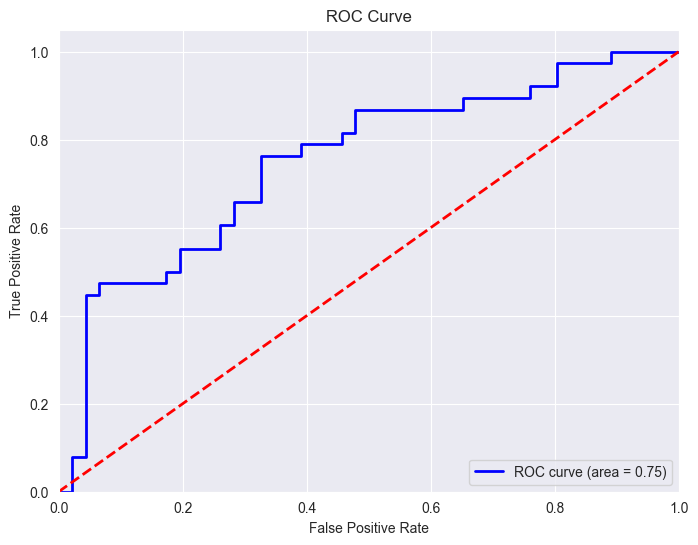

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Model: Random Forest
Best parameters: {'model__n_estimators': 200, 'model__max_depth': 10}
Accuracy: 0.7380952380952381
Classification report:
               precision    recall  f1-score   support

           0       0.71      0.87      0.78        46
           1       0.79      0.58      0.67        38

    accuracy                           0.74        84
   macro avg       0.75      0.72      0.73        84
weighted avg       0.75      0.74      0.73        84



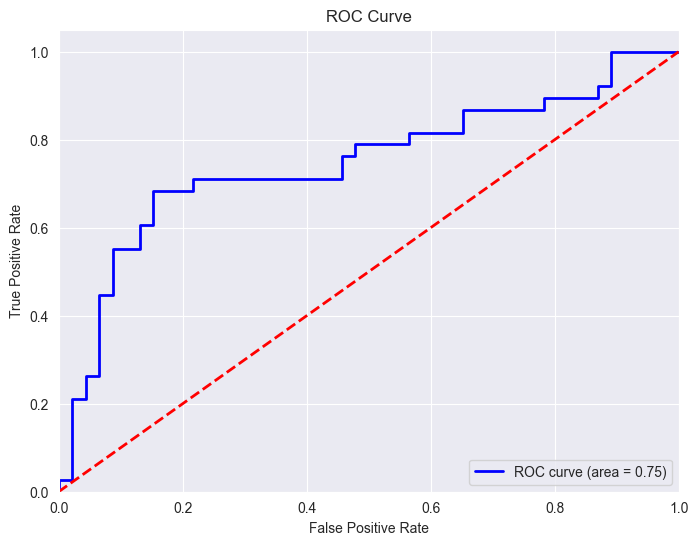

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Model: Gradient Boosting
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 3, 'model__learning_rate': 0.01}
Accuracy: 0.7023809523809523
Classification report:
               precision    recall  f1-score   support

           0       0.68      0.87      0.76        46
           1       0.76      0.50      0.60        38

    accuracy                           0.70        84
   macro avg       0.72      0.68      0.68        84
weighted avg       0.72      0.70      0.69        84



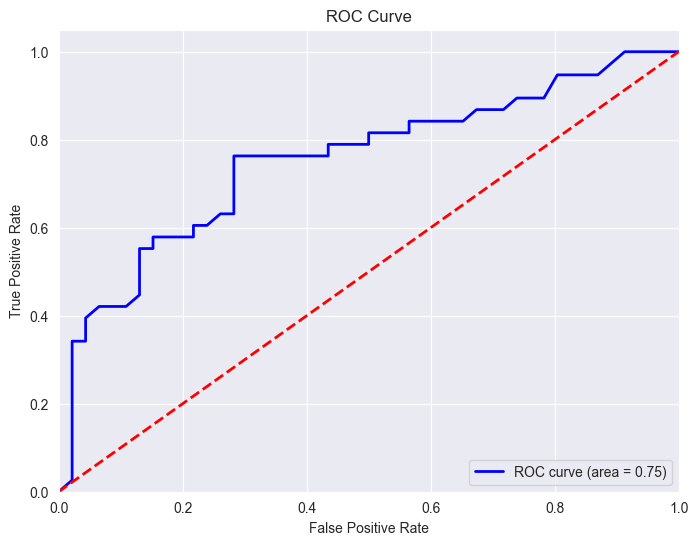

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Model: XGBoost
Best parameters: {'model__max_depth': 3, 'model__learning_rate': 0.01}
Accuracy: 0.6666666666666666
Classification report:
               precision    recall  f1-score   support

           0       0.66      0.80      0.73        46
           1       0.68      0.50      0.58        38

    accuracy                           0.67        84
   macro avg       0.67      0.65      0.65        84
weighted avg       0.67      0.67      0.66        84



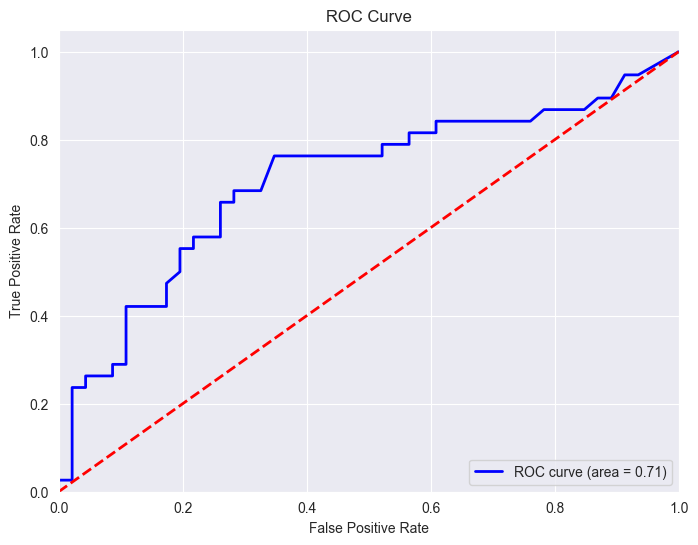

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,roc_curve,roc_auc_score,classification_report,confusion_matrix
from  matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

models = [
    ("Logistic Regression",LogisticRegression()),
    ("Random Forest", RandomForestClassifier()),
    ("Gradient Boosting",GradientBoostingClassifier()),
    ("XGBoost",XGBClassifier())
]

for name, model in models:
    pipeline = Pipeline([("preprocessor",preprocessor),
                         ("model",model)])
    param_distributions = {}
    if name == "Logistic Regression":
        param_distributions = {
            "model__C":[0.01,0.1,1,10],
            "model__penalty":["l1","l2"],
            "model__solver":["liblinear"]
        }
    elif name == "Random Forest":
        param_distributions = {
            "model__n_estimators":[100,200],
            "model__max_depth":[None, 10,20]
        }
    elif name =="Gradient Boosting":
        param_distributions = {
            "model__n_estimators":[100,200],
            "model__learning_rate":[0.01,0.1],
            "model__max_depth":[3,4,5]
        }
    elif name =="XGBoost":
        param_distributions = {
            "model__max_depth":[3,4,5],
            "model__learning_rate":[0.01,0.1]
        }
    randomized_search = RandomizedSearchCV(
        pipeline,
        param_distributions,
        # n_iter= 20,
        cv=3,
        scoring="roc_auc",
        verbose=3,
        n_jobs=3
    )
    randomized_search.fit(X_train,y_train)
    best_model = randomized_search.best_estimator_
    y_pred = best_model.predict(X_val)
    print("Model:",name)
    print("Best parameters:",randomized_search.best_params_)
    print("Accuracy:",accuracy_score(y_val,y_pred))
    print("Classification report:\n",classification_report(y_val,y_pred))

    if hasattr(best_model.named_steps["model"], "predict_proba"):
        y_pred_proba = best_model.predict_proba(X_val)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
        roc_auc = roc_auc_score(y_val, y_pred_proba)

        plt.figure(figsize=(8, 6))
        plt.plot(
            fpr, tpr, color="blue", lw=2, label="ROC curve (area = %0.2f)" % roc_auc
        )
        plt.plot([0, 1], [0, 1], color="red", lw=2, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend(loc="lower right")
        plt.show()


In [52]:
!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 1.9 MB/s eta 0:01:21
   ---------------------------------------- 1.0/150.0 MB 1.9 MB/s eta 0:01:17
   ---------------------------------------- 1.6/150.0 MB 2.0 MB/s eta 0:01:15
    --------------------------------------- 2.1/150.0 MB 2.1 MB/s eta 0:01:12
    --------------------------------------- 2.6/150.0 MB 2.1 MB/s eta 0:01:10
    --------------------------------------- 2.9/150.0 MB 2.1 MB/s eta 0:01:10
    --------------------------------------- 3.4/150.0 MB 2.1 MB/s eta 0:01:09
   - -------------------------------------- 3.9/150.0 MB 2.2 MB/s eta 0:01:08
   - -------------------------------------- 4.7/150.0 MB 2.3 MB/s eta 0:01:05
   - -------------------------------------- 5.2/150.0 MB 2.3 MB/s eta 0:01:03
   - -------------------------------------- 5.8/150.0 MB 2.4 MB/s eta 0:01:01
